In [127]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu
import array_utils as au


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:

trial_file = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv'
trial_df = pd.read_csv(trial_file)

In [141]:
# Explore new custom dataframe

bonsai_df = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/new_bonsai_df_cleaned.csv')

bonsai_df = bu.add_session_column(bonsai_df)

In [142]:
print(f'Session DF: {session_df.describe()}')
print(f'Bonsai DF: {bonsai_df.describe()}')

Session DF:           subject_id     nwb_suffix  experiment_description  \
count    6643.000000    6643.000000                     0.0   
mean   724763.899744  118123.913292                     NaN   
std     23160.286929   38228.723947                     NaN   
min    567890.000000       0.000000                     NaN   
25%    710107.000000   93705.000000                     NaN   
50%    722679.000000  120013.000000                     NaN   
75%    745502.000000  143327.500000                     NaN   
max    776296.000000  215845.000000                     NaN   

       session_run_time_in_min  water_in_session_foraging  \
count              6643.000000                6496.000000   
mean                 71.607858                   0.489365   
std                  19.433576                   0.270716   
min                   0.000000                   0.000000   
25%                  64.000000                   0.354000   
50%                  75.000000                   0.474

In [143]:
bonsai_df.columns.to_list()

['subject_id',
 'session_date',
 'nwb_suffix',
 'rig',
 'user_name',
 'experiment_description',
 'task',
 'notes',
 'session_start_time',
 'session_end_time',
 'session_run_time_in_min',
 'water_in_session_foraging',
 'water_in_session_manual',
 'water_in_session_total',
 'water_after_session',
 'water_day_total',
 'base_weight',
 'target_weight',
 'target_weight_ratio',
 'weight_after',
 'laser_1_calibration_power',
 'laser_2_calibration_power',
 'laser_1_target_areas',
 'laser_2_target_areas',
 'commit_ID',
 'repo_url',
 'current_branch',
 'weight_after_ratio',
 'p_reward_sum_mean',
 'p_reward_sum_std',
 'p_reward_sum_median',
 'p_reward_contrast_mean',
 'p_reware_contrast_median',
 'effective_block_length_mean',
 'effective_block_length_std',
 'effective_block_length_median',
 'effective_block_length_min',
 'effective_block_length_max',
 'duration_gocue_stop_mean',
 'duration_gocue_stop_std',
 'duration_gocue_stop_median',
 'duration_gocue_stop_min',
 'duration_gocue_stop_max',
 'du

In [145]:
# Filtering

bonsai_df = bonsai_df.loc[:, ['subject_id', 'session_date', 
                                     'new_session', 'curriculum_name', 'curriculum_version', 
                                     'current_stage_actual', 'task', 'p_reward_sum_mean', 
                                     'effective_block_length_mean','autowater_collected', 'autowater_ignored',
                                     'ignore_rate', 'reward_rate', 'finished_rate', 'double_dipping_rate_finished_trials',
                                     'double_dipping_rate_finished_reward_trials',
                                     'double_dipping_rate_finished_noreward_trials',
                                     'lick_consistency_mean_finished_trials',
                                     'lick_consistency_mean_finished_reward_trials',
                                     'lick_consistency_mean_finished_noreward_trials',
                                     'foraging_performance', 'foraging_eff', 'foraging_eff_random_seed',
                                     'foraging_choice', 'foraging_choice_global','early_lick_rate', 
                                     'invalid_lick_ratio', 'double_dipping_rate_finished_trials', 
                                     'lick_consistency_mean_finished_trials','reaction_time_mean']]

bonsai_df.columns.to_list()


KeyError: "['foraging_eff_random_seed', 'foraging_choice', 'foraging_choice_global'] not in index"

##### Explore feature distributions and variability

In [75]:
# Feature notes

# finished rate -- upwards increase at stage level, plateu at session 20

# ignore rate -- downwards decrease at stage level, plateu at session 20

# reward rate -- V shape (STAGE_3) at stage level, sig. decrease until session 10 then slow decrease

# median reaction time -- normal (but only until STAGE_FINAL) decrease at stage level, ONLY until session ~7

# mean reaction time -- normal (but only until STAGE_FINAL) decrease at stage level, ONLY until session ~7

# early lick rate -- upwards V shape (STAGE_3) at stage level, plateu at session 20

# invalid lick ratio -- slight increase at stage level (but only until STAGE_FINAL), ONLY until session ~7

# double dipping rate (finished trials) -- large decrease at until STAGE_2, then flat,  plateu at session 20

# double dipping rate rewarded (finished trials) -- decrease at stage level,  plateu at session 10

# double dipping rate non-rewarded (finished trials) -- decrease at stage level but only until STAGE_2,  plateu at session 10

# lick consistency mean (finished trials) -- increase at stage level, plateu at session 20

# lick consistency mean (finished reward trials) -- increase at stage level, plateu at session 10

# lick consistency mean (finished non-rewarded trials) -- increase until STAGE 3, then slight decrease, plateu at session 10



In [137]:
# Define stage order

stage_order = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']
bonsai_df['current_stage_actual'] = pd.Categorical(bonsai_df['current_stage_actual'], categories=stage_order)


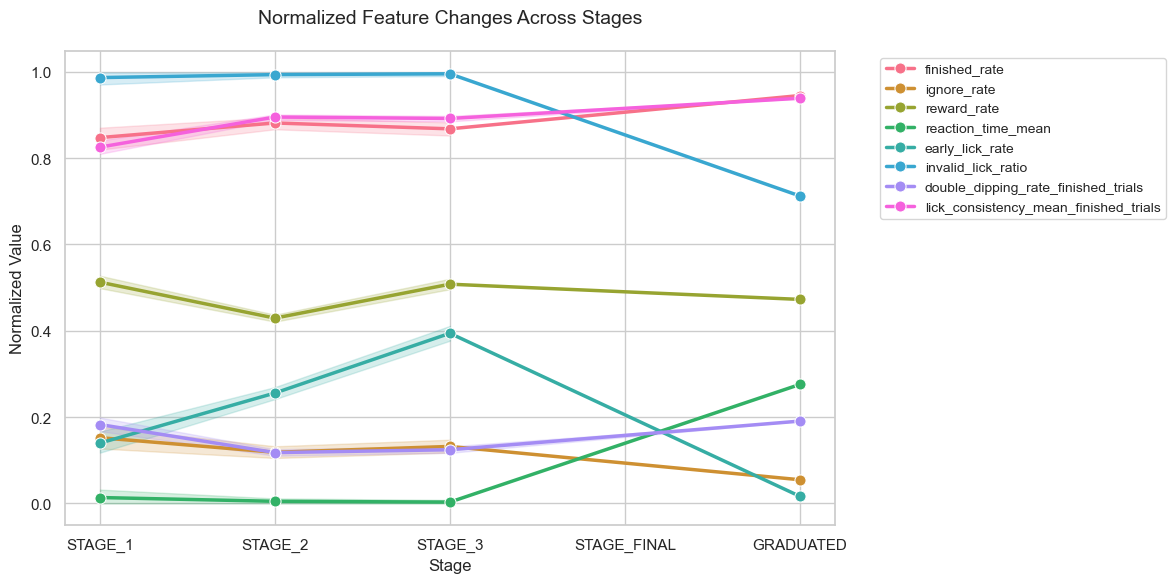

In [140]:
# Create normalized versions of each feature by stage
normalized_df = bonsai_df.copy()

# Drop STAGE_FINAL rows
normalized_df = normalized_df[normalized_df['current_stage_actual'] != 'STAGE_FINAL']

# Define feature names as strings
features = [
    'finished_rate', 
    'ignore_rate', 
    'reward_rate', 
    'reaction_time_mean', 
    'early_lick_rate',
    'invalid_lick_ratio', 
    'double_dipping_rate_finished_trials',
    'lick_consistency_mean_finished_trials'
]

# First normalize all features
for feature in features:
    # Normalize within each stage
    normalized_df[feature] = normalized_df.groupby('current_stage_actual')[feature].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x
    )

# Melt the dataframe to get it into the right format for seaborn
melted_df = normalized_df.melt(
    id_vars=['current_stage_actual'],
    value_vars=features,
    var_name='Feature',
    value_name='Normalized Value'
)

# Create figure
plt.figure(figsize=(12, 6))

# Plot using the melted dataframe
sns.lineplot(
    data=melted_df,
    x='current_stage_actual',
    y='Normalized Value',
    hue='Feature',
    linewidth=2.5,
    marker='o',
    markersize=8
)

plt.title('Normalized Feature Changes Across Stages', fontsize=14, pad=20)
plt.xlabel('Stage', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [125]:
# Create normalized versions of each feature by session groups (groups of 5 sessions)
normalized_df = session_df_filt.copy()
session_groups = pd.qcut(normalized_df['new_session'], q=10, labels=False)  # Create 10 session groups
for feature in features_to_normalize:
    # Normalize within each session group
    normalized_df[feature] = normalized_df.groupby(session_groups)[feature].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x
    )

# Create plot with improved styling
plt.figure(figsize=(20, 10))
sns.set_style("whitegrid")
sns.set_palette("husl")

# Plot normalized features by session with larger line width and alpha
for feature, label in [
    (finished_rate, 'Finished Rate'),
    (ignore_rate, 'Ignore Rate'),
    (reward_rate, 'Reward Rate'),
    (mean_reaction_time, 'Mean Reaction Time'),
    (early_lick_rate, 'Early Lick Rate'),
    (invalid_lick_ratio, 'Invalid Lick Ratio'),
    (double_dipping_rate_finished_trials, 'Double Dipping Rate'),
    (lick_consistency_mean_finished_trials, 'Lick Consistency')
]:
    sns.lineplot(
        data=normalized_df,
        x='new_session',
        y=feature,
        label=label,
        linewidth=2.5,
        marker='o',
        markersize=6
    )

plt.title('Normalized Feature Changes Across Sessions', fontsize=14, pad=20)
plt.xlabel('Session Number', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

KeyError: 'Column not found: reaction_time_mean'

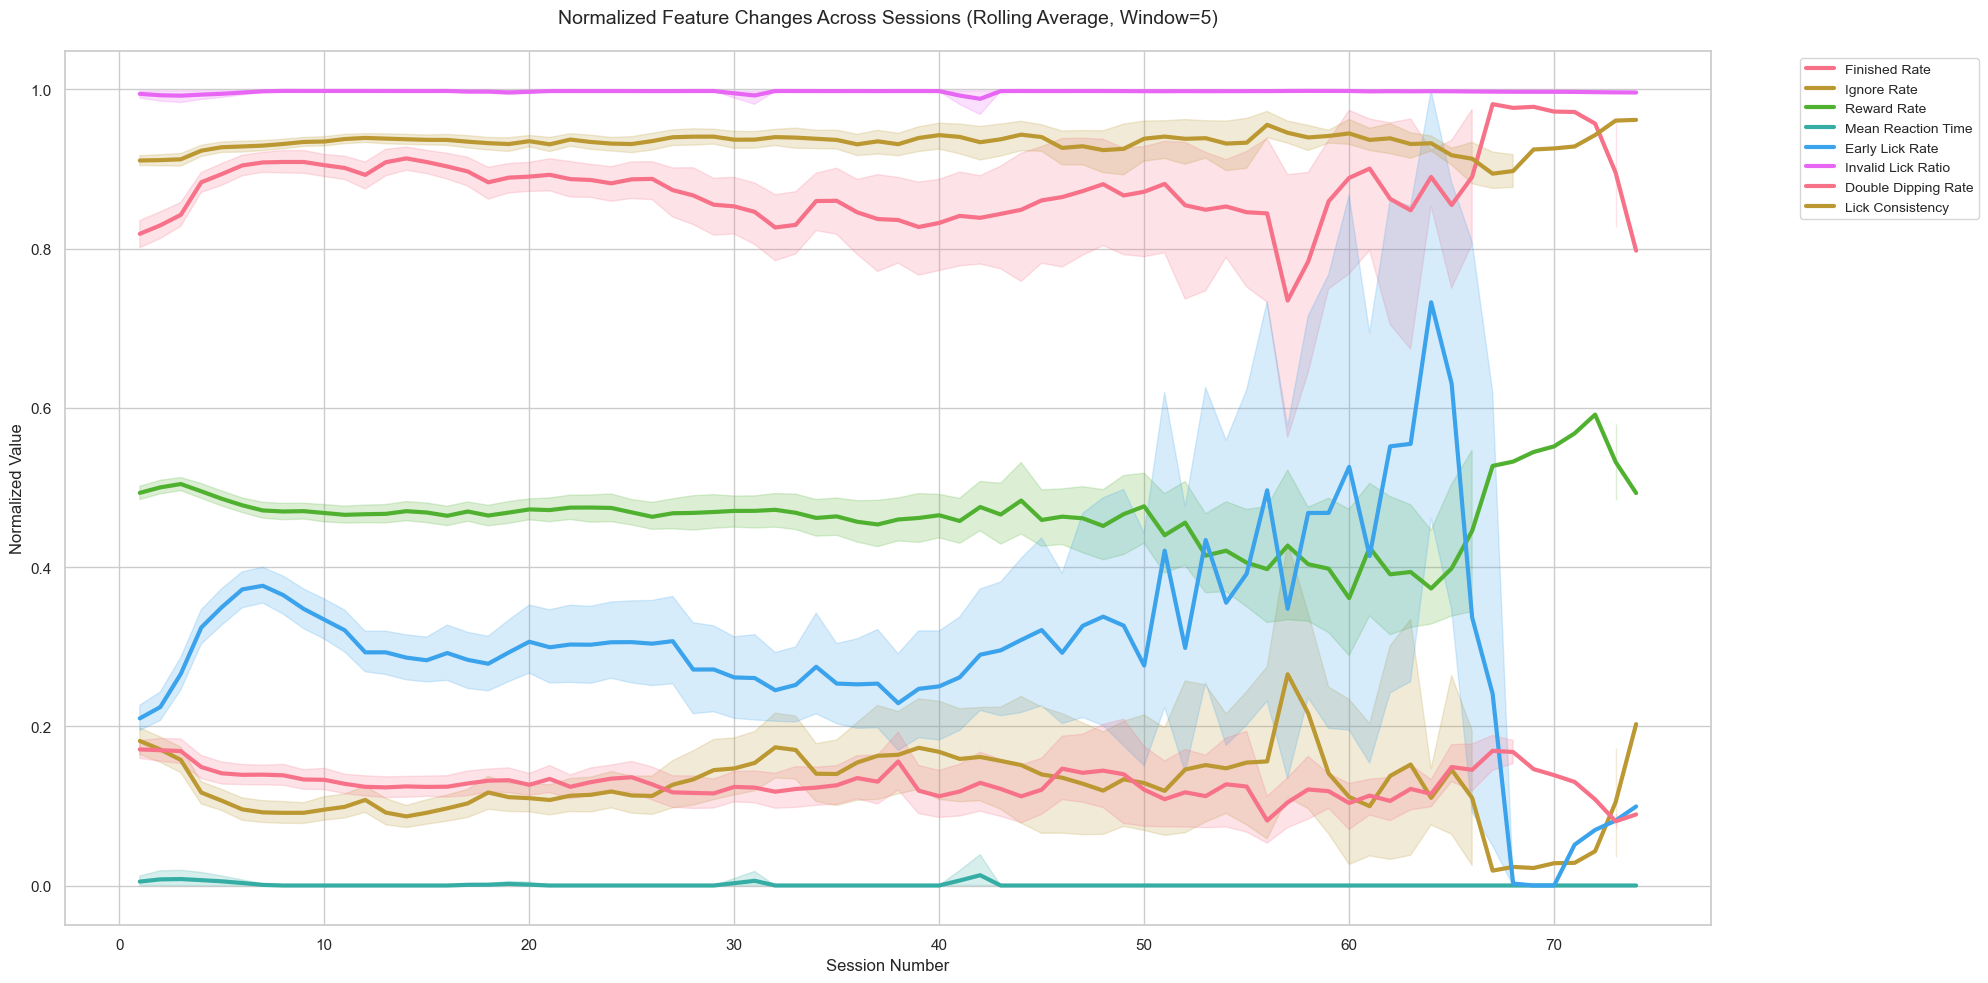

In [100]:
# Create normalized versions of each feature by session groups
normalized_df = session_df.copy()
window_size = 5  # Size of rolling window

for feature in features_to_normalize:
    # Normalize overall to maintain scale
    min_val = normalized_df[feature].min()
    max_val = normalized_df[feature].max()
    normalized_df[feature] = (normalized_df[feature] - min_val) / (max_val - min_val)
    # Apply rolling average
    normalized_df[feature] = normalized_df[feature].rolling(window=window_size, center=True).mean()

# Create plot with improved styling
plt.figure(figsize=(20, 10))
sns.set_style("whitegrid")
sns.set_palette("husl")

# Plot smoothed features by session
for feature, label in [
    (finished_rate, 'Finished Rate'),
    (ignore_rate, 'Ignore Rate'),
    (reward_rate, 'Reward Rate'),
    (mean_reaction_time, 'Mean Reaction Time'),
    (early_lick_rate, 'Early Lick Rate'),
    (invalid_lick_ratio, 'Invalid Lick Ratio'),
    (double_dipping_rate_finished_trials, 'Double Dipping Rate'),
    (lick_consistency_mean_finished_trials, 'Lick Consistency')
]:
    sns.lineplot(
        data=normalized_df,
        x='new_session',
        y=feature,
        label=label,
        linewidth=3,
    )

plt.title(f'Normalized Feature Changes Across Sessions (Rolling Average, Window={window_size})', 
         fontsize=14, pad=20)
plt.xlabel('Session Number', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [104]:
# Test dev
import itertools

learning_metric = (
    (2 * finished_rate * reward_rate * lick_consistency_mean_finished_trials) /
    (1 + early_lick_rate + 2 * double_dipping_rate_finished_trials + invalid_lick_ratio)
)

# Test weighting
for w1, w2, w3 in itertools.product([1,2,3], repeat=3):
    metric = (
        (w1 * finished_rate * w2 * reward_rate * w3 * lick_consistency_mean_finished_trials) /
        (1 + early_lick_rate + double_dipping_rate_finished_trials + invalid_lick_ratio)
    )

# Check if metric increases across stages
sns.boxplot(data=normalized_df, x='current_stage_actual', y='learning_metric')

TypeError: can't multiply sequence by non-int of type 'str'

In [102]:
# Protyping metrics
test_session_df = session_df.copy()

# Testing filtering
version = '2.3'
version_filt_test_session_df = test_session_df[test_session_df['curriculum_version'] == version]
curriculum_name = 'Uncoupled Baiting'
curriculum_filt_test_session_df = test_session_df[test_session_df['curriculum_name'] == curriculum_name]


# Prototype metric 1: 1 / (early lick rate + double dipping rate)
curriculum_filt_test_session_df['prototype_metric_1'] = np.where(
    (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials']) != 0,
    (1/ (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'])),
    np.inf
)

# Prototype metric 2: finished rate / (early lick rate + double dipping rate)
curriculum_filt_test_session_df['prototype_metric_2'] = np.where(
    (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['finished_rate']) != 0,
    (curriculum_filt_test_session_df['finished_rate'] / (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'])),
    np.inf
)

# Prototype metric 3: finished rate / (double dipping rate + reaction time*0.0001)
curriculum_filt_test_session_df['prototype_metric_3'] = np.where(
    (curriculum_filt_test_session_df['finished_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['reaction_time_mean']) != 0,
    ((curriculum_filt_test_session_df['finished_rate'] / curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + (curriculum_filt_test_session_df['reaction_time_mean']*0.0001))),
    np.inf
)

# Prototype metric 4: finished rate / (finished rate + double dipping rate + reaction time)
curriculum_filt_test_session_df['prototype_metric_4'] = np.where(
    (curriculum_filt_test_session_df['finished_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['reaction_time_mean']) != 0,
    (curriculum_filt_test_session_df['finished_rate'] / (curriculum_filt_test_session_df['finished_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['reaction_time_mean'])),
    np.inf
)

# Prototype metric 5: finished rate * lick consistency / (1 + early_lick_rate + double_dipping_rate)
curriculum_filt_test_session_df['prototype_metric_5'] = (
    (2 * curriculum_filt_test_session_df['finished_rate'] * curriculum_filt_test_session_df['reward_rate'] * 
     curriculum_filt_test_session_df['lick_consistency_mean_finished_trials']) /
    (1 + curriculum_filt_test_session_df['early_lick_rate'] + 
     2 * curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] +
     curriculum_filt_test_session_df['invalid_lick_ratio'])
)

# Preprocessing 
curriculum_filt_test_session_df = bu.clean_dataframe(curriculum_filt_test_session_df, threshold=0.5, verbose=True)
curriculum_filt_test_session_df = bu.add_session_column(curriculum_filt_test_session_df)

# Define stage order
stage_order = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']
curriculum_filt_test_session_df['current_stage_actual'] = pd.Categorical(curriculum_filt_test_session_df['current_stage_actual'], categories=stage_order)

Removed 0 rows with more than 50.0% NaN values

Remaining NaN counts per column:
experiment_description                            2141
laser_1_calibration_power                         2141
laser_2_calibration_power                         2141
laser_1_target_areas                              2141
laser_2_target_areas                              2141
notes                                             1659
lickspout_movement_range_x                         454
lickspout_median_pos_z                             454
lickspout_median_pos_y                             454
lickspout_median_pos_x                             454
lickspout_movement_range_z                         454
lickspout_movement_range_y                         454
lickspout_initial_pos_y                            453
lickspout_initial_pos_x                            453
lickspout_initial_pos_z                            453
weight_after_ratio                                 124
water_in_session_manual                

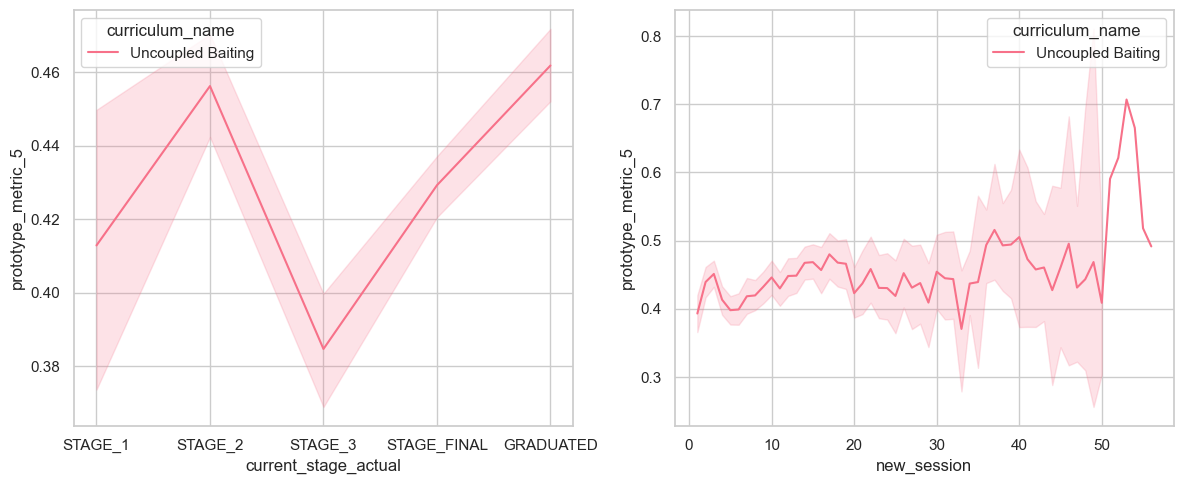

In [103]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='prototype_metric_5', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='prototype_metric_5', 
             hue='curriculum_name', ax=ax2)

plt.tight_layout()

In [77]:
# Protyping metrics

test_session_df = session_df.copy()

# Testing filtering
version = '2.3'
version_filt_test_session_df = test_session_df[test_session_df['curriculum_version'] == version]
curriculum_name = 'Uncoupled Baiting'
curriculum_filt_test_session_df = test_session_df[test_session_df['curriculum_name'] == curriculum_name]


# Prototype metric 1: 1 / (early lick rate + double dipping rate)
curriculum_filt_test_session_df['prototype_metric_1'] = np.where(
    (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials']) != 0,
    (1/ (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'])),
    np.inf
)

# Prototype metric 2: finished rate / (early lick rate + double dipping rate)
curriculum_filt_test_session_df['prototype_metric_2'] = np.where(
    (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['finished_rate']) != 0,
    (curriculum_filt_test_session_df['finished_rate'] / (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'])),
    np.inf
)

# Prototype metric 3: finished rate / (double dipping rate + reaction time*0.0001)
curriculum_filt_test_session_df['prototype_metric_3'] = np.where(
    (curriculum_filt_test_session_df['finished_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['reaction_time_mean']) != 0,
    ((curriculum_filt_test_session_df['finished_rate'] / curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + (curriculum_filt_test_session_df['reaction_time_mean']*0.0001))),
    np.inf
)

# Prototype metric 4: finished rate / (finished rate + double dipping rate + reaction time)
curriculum_filt_test_session_df['prototype_metric_4'] = np.where(
    (curriculum_filt_test_session_df['finished_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['reaction_time_mean']) != 0,
    (curriculum_filt_test_session_df['finished_rate'] / (curriculum_filt_test_session_df['finished_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['reaction_time_mean'])),
    np.inf
)

# Prototype metric 5: finished rate * lick consistency / (1 + early_lick_rate + double_dipping_rate)
curriculum_filt_test_session_df['prototype_metric_5'] = (
    (2 * curriculum_filt_test_session_df['finished_rate'] * curriculum_filt_test_session_df['reward_rate'] * 
     curriculum_filt_test_session_df['lick_consistency_mean_finished_trials']) /
    (1 + curriculum_filt_test_session_df['early_lick_rate'] + 
     2 * curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] +
     curriculum_filt_test_session_df['invalid_lick_ratio'])
)

# Preprocessing 
#test_session_df = bu.filter_by_group_size(test_session_df, group_col='subject_id', max_rows=30)
curriculum_filt_test_session_df = bu.clean_dataframe(curriculum_filt_test_session_df, threshold=0.5, verbose=True)
curriculum_filt_test_session_df = bu.add_session_column(curriculum_filt_test_session_df)

# Define stage order
stage_order = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']
curriculum_filt_test_session_df['current_stage_actual'] = pd.Categorical(curriculum_filt_test_session_df['current_stage_actual'], categories=stage_order)

Removed 0 rows with more than 50.0% NaN values

Remaining NaN counts per column:
experiment_description                            2141
laser_1_calibration_power                         2141
laser_2_calibration_power                         2141
laser_1_target_areas                              2141
laser_2_target_areas                              2141
notes                                             1659
lickspout_movement_range_x                         454
lickspout_median_pos_z                             454
lickspout_median_pos_y                             454
lickspout_median_pos_x                             454
lickspout_movement_range_z                         454
lickspout_movement_range_y                         454
lickspout_initial_pos_y                            453
lickspout_initial_pos_x                            453
lickspout_initial_pos_z                            453
weight_after_ratio                                 124
water_in_session_manual                

In [78]:
bu.analyze_column_distribution(curriculum_filt_test_session_df, 'curriculum_name')

{'value_counts': curriculum_name
 Uncoupled Baiting    2141
 Name: count, dtype: int64,
 'percentages': curriculum_name
 Uncoupled Baiting    100.0
 Name: proportion, dtype: float64,
 'total_count': 2141,
 'unique_values': 1,
 'most_common': ('Uncoupled Baiting', 2141),
 'least_common': ('Uncoupled Baiting', 2141)}

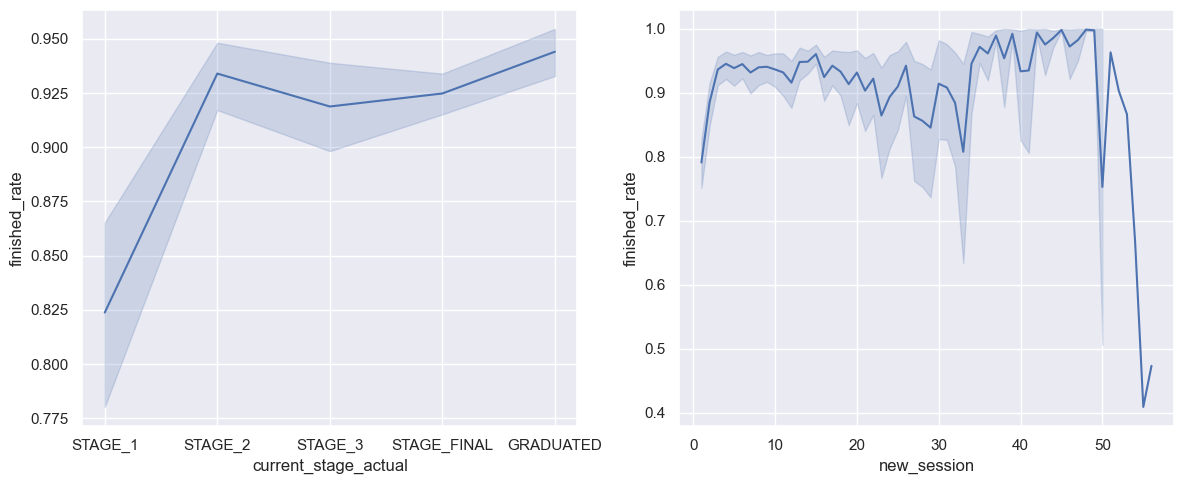

In [79]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='finished_rate', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='finished_rate', 
             ax=ax2)


plt.tight_layout()

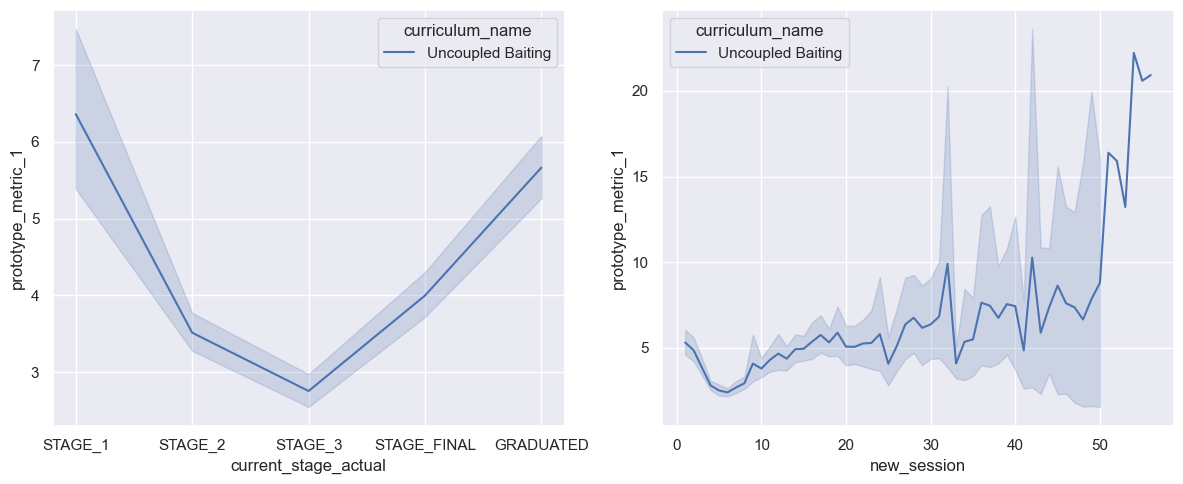

In [80]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='prototype_metric_1', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='prototype_metric_1', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

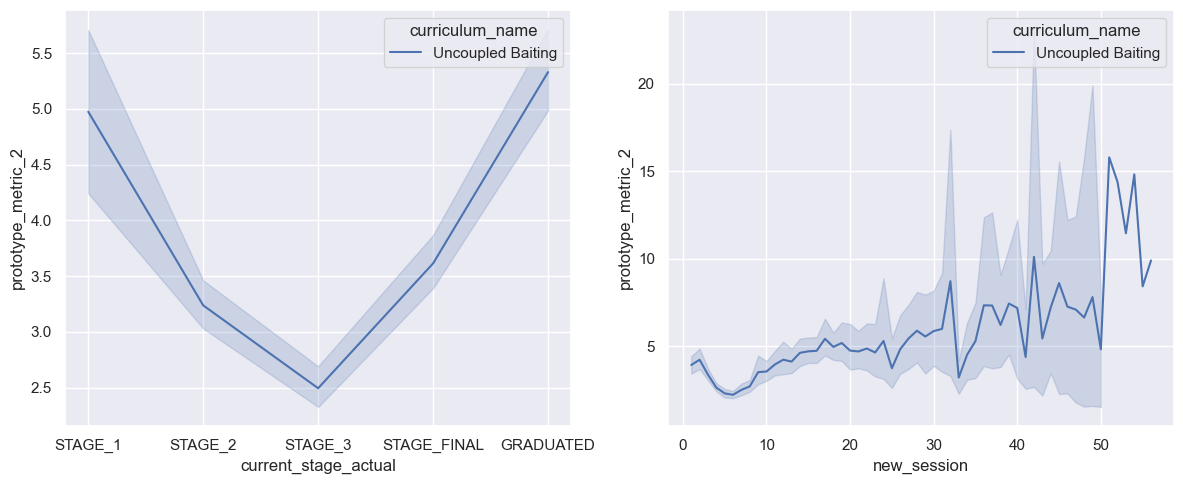

In [81]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='prototype_metric_2', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='prototype_metric_2', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

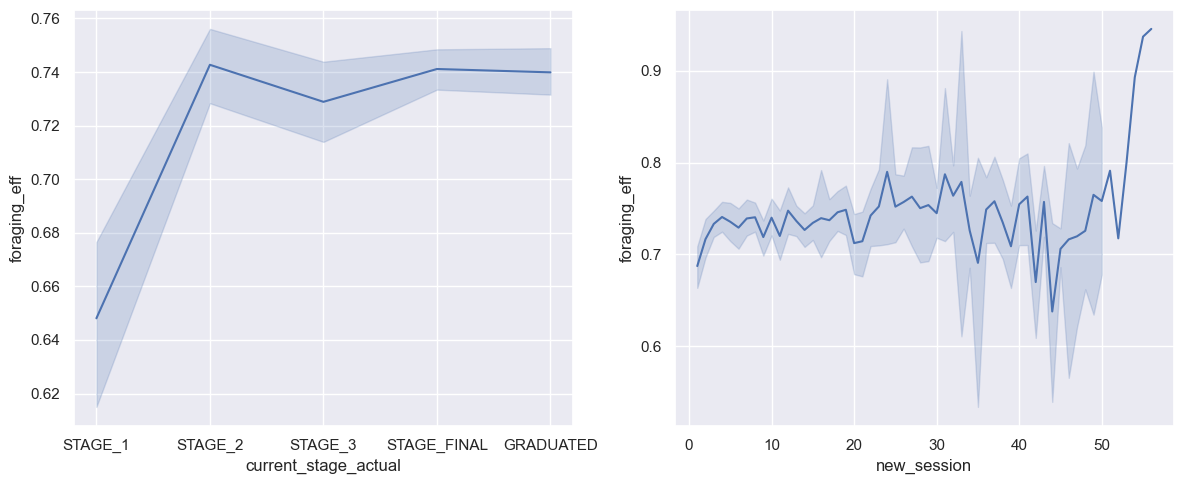

In [82]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='foraging_eff', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='foraging_eff', 
              ax=ax2)


plt.tight_layout()

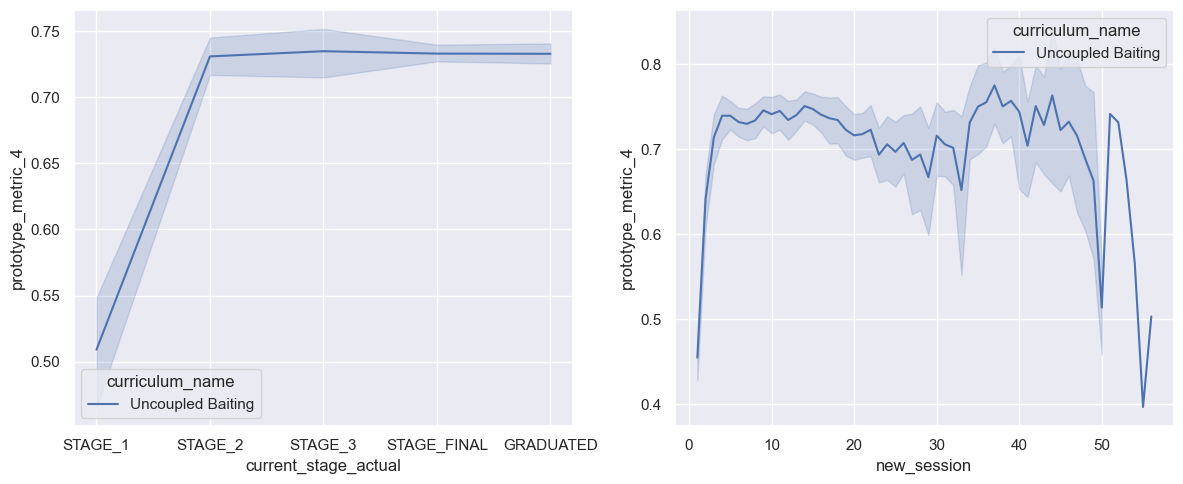

In [83]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='prototype_metric_4', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='prototype_metric_4', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

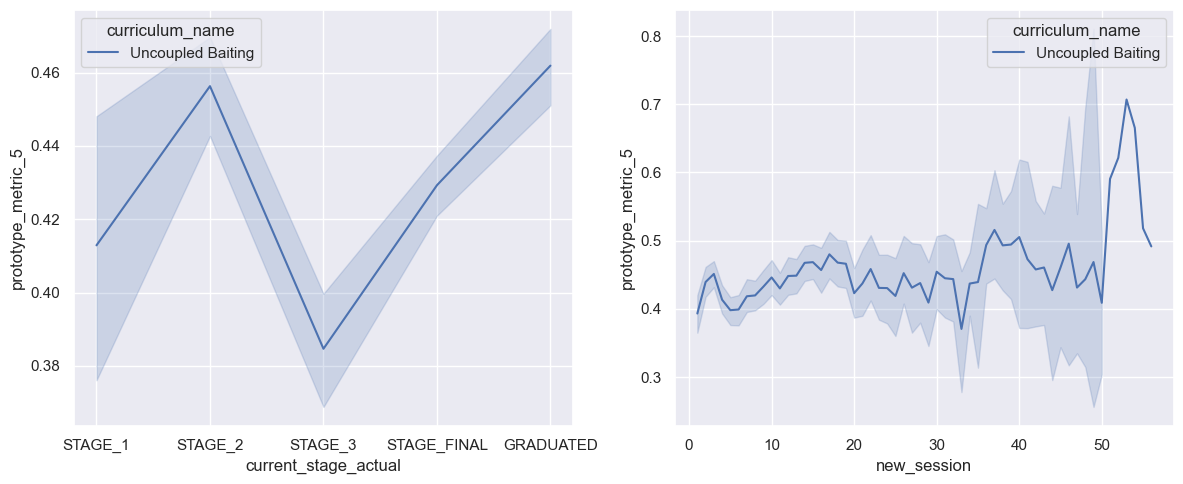

In [84]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='prototype_metric_5', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='prototype_metric_5', 
             hue='curriculum_name', ax=ax2)

plt.tight_layout()

In [85]:
# Array utils
array_df = curriculum_filt_test_session_df.copy()

# Create custom group limits
stage_counts = array_df.groupby(['subject_id', 'current_stage_actual']).size().unstack(fill_value=0)
stage_lims = {stage: int(stage_counts[stage].quantile(0.95)) for stage in stage_counts.columns}

array_df = bu.filter_by_group_size(array_df, 
                                   group_col='subject_id', 
                                   category_col='current_stage_actual', 
                                   category_limits=stage_lims)


# Generate prototype metric arrays

# Prototype metric 5
prot_type_five = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric='prototype_metric_5', 
                          task_col=None)

# Prototype metric 4
prot_type_four = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric='prototype_metric_4', 
                          task_col=None)

# Generate foraging eff array for comparison
foraging_eff_array = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric='foraging_eff', 
                          task_col=None)

# Univariate arrays
uni_arrays = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric= 'finished_rate', 
                          task_col=None)



# Summary statistics
au.summary_statistics(prot_type_four)

No data found for nan
No data found for nan
No data found for nan
No data found for nan


,Stage,Task,Array Shape,Mean,Std Dev,Min,Max,Outliers
0,STAGE_1,N/A,"(85, 3)",0.458824,0.678284,0,3,0
1,STAGE_2,N/A,"(85, 3)",1.870588,0.664888,0,3,0
2,STAGE_3,N/A,"(85, 4)",1.082353,0.689617,0,4,0
3,STAGE_FINAL,N/A,"(85, 17)",7.329412,4.091277,0,16,0
4,GRADUATED,N/A,"(85, 20)",4.541176,5.312699,0,20,0


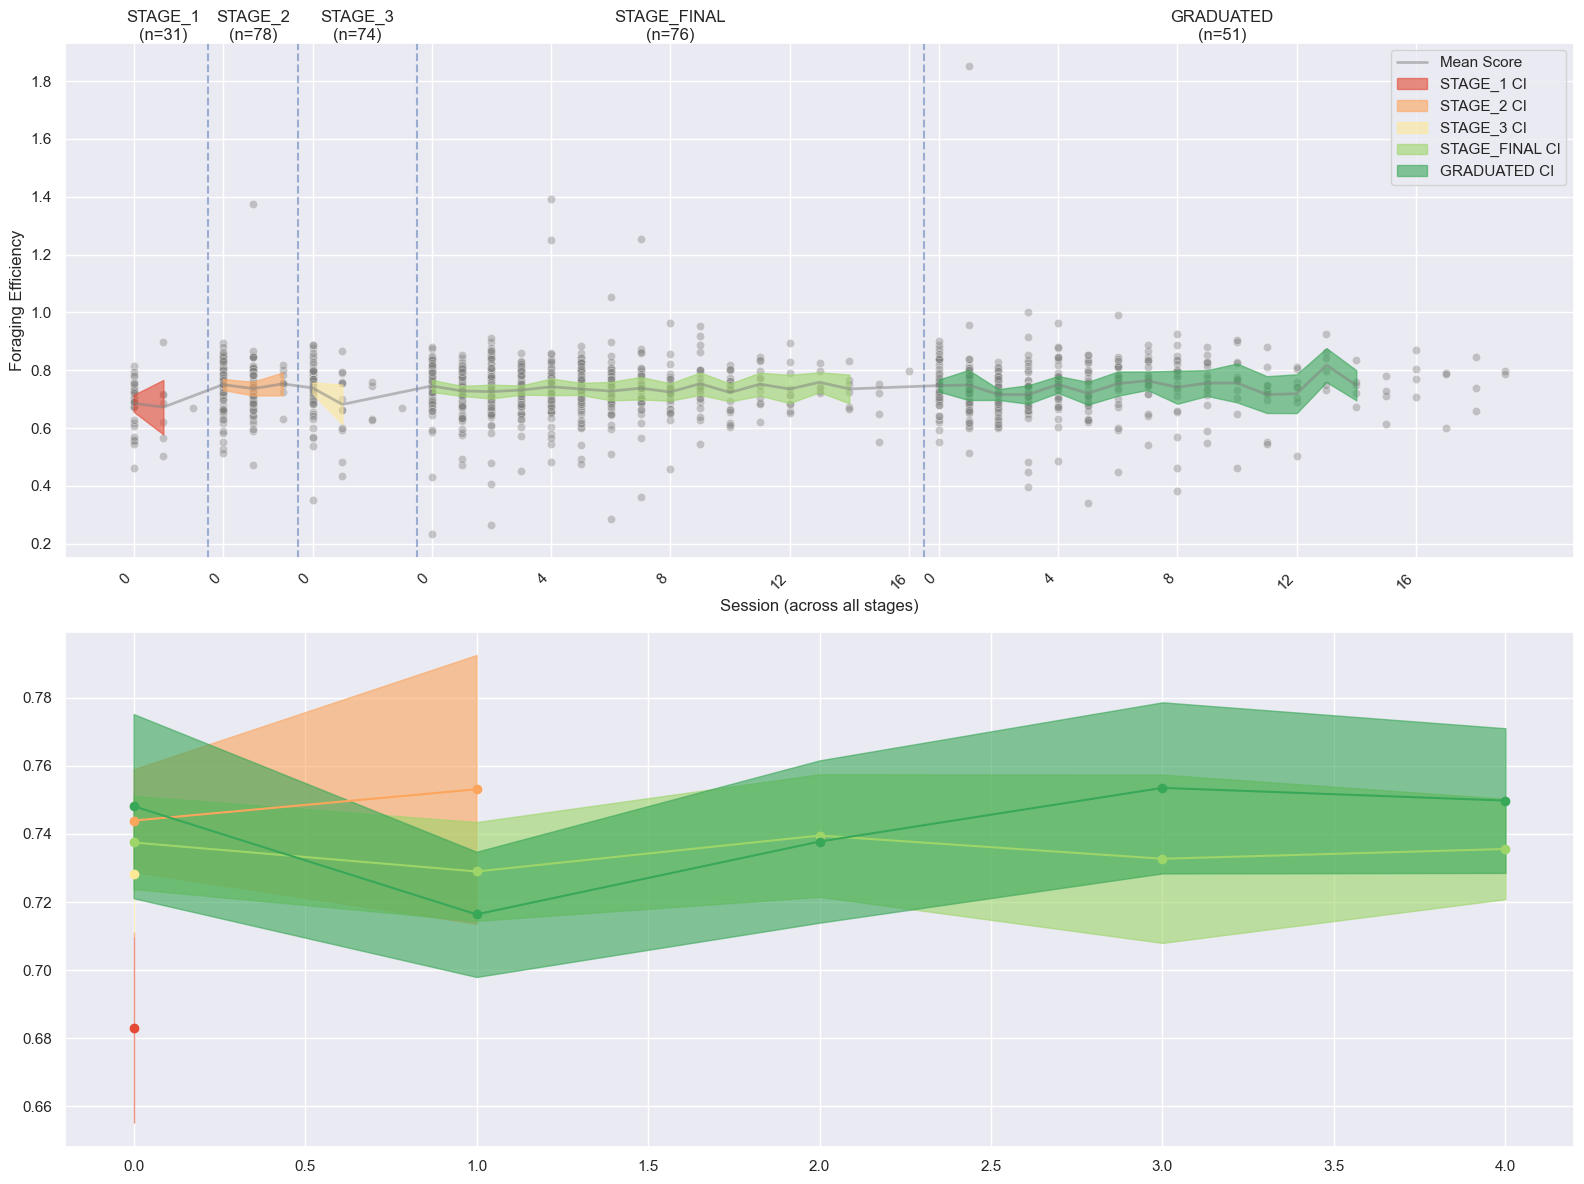


Detailed Statistics by Stage:
               N   Mean    Std    SEM    Min    Max  Subjects
Stage                                                        
GRADUATED    386  0.741  0.107  0.005  0.341  1.852        51
STAGE_1       39  0.683  0.089  0.014  0.464  0.898        31
STAGE_2      159  0.744  0.093  0.007  0.471  1.375        78
STAGE_3       92  0.728  0.091  0.010  0.350  0.889        74
STAGE_FINAL  623  0.735  0.094  0.004  0.233  1.391        76

Outlier Analysis:

STAGE_2:
Number of outliers: 1
Outlier values: [1.37548428]
Percentage: 0.6%

STAGE_3:
Number of outliers: 2
Outlier values: [0.35019353 0.4355183 ]
Percentage: 2.2%

STAGE_FINAL:
Number of outliers: 11
Outlier values: [0.2325939  0.4311548  0.26572893 0.40735634 0.45017541 1.39088983
 1.24911376 1.05190224 0.28437048 0.36323902 1.25313283]
Percentage: 1.8%

GRADUATED:
Number of outliers: 4
Outlier values: [1.85225523 0.39569442 0.34120633 0.38361172]
Percentage: 1.0%

Performance Summary:

STAGE_1:
Sessions: 

In [86]:
au.ci_plot_metric(foraging_eff_array, 
           verbose=True,
           min_sample_threshold=5,
           ci_level=0.95,
           zscore_threshold=3,
           normalize_stages=True)

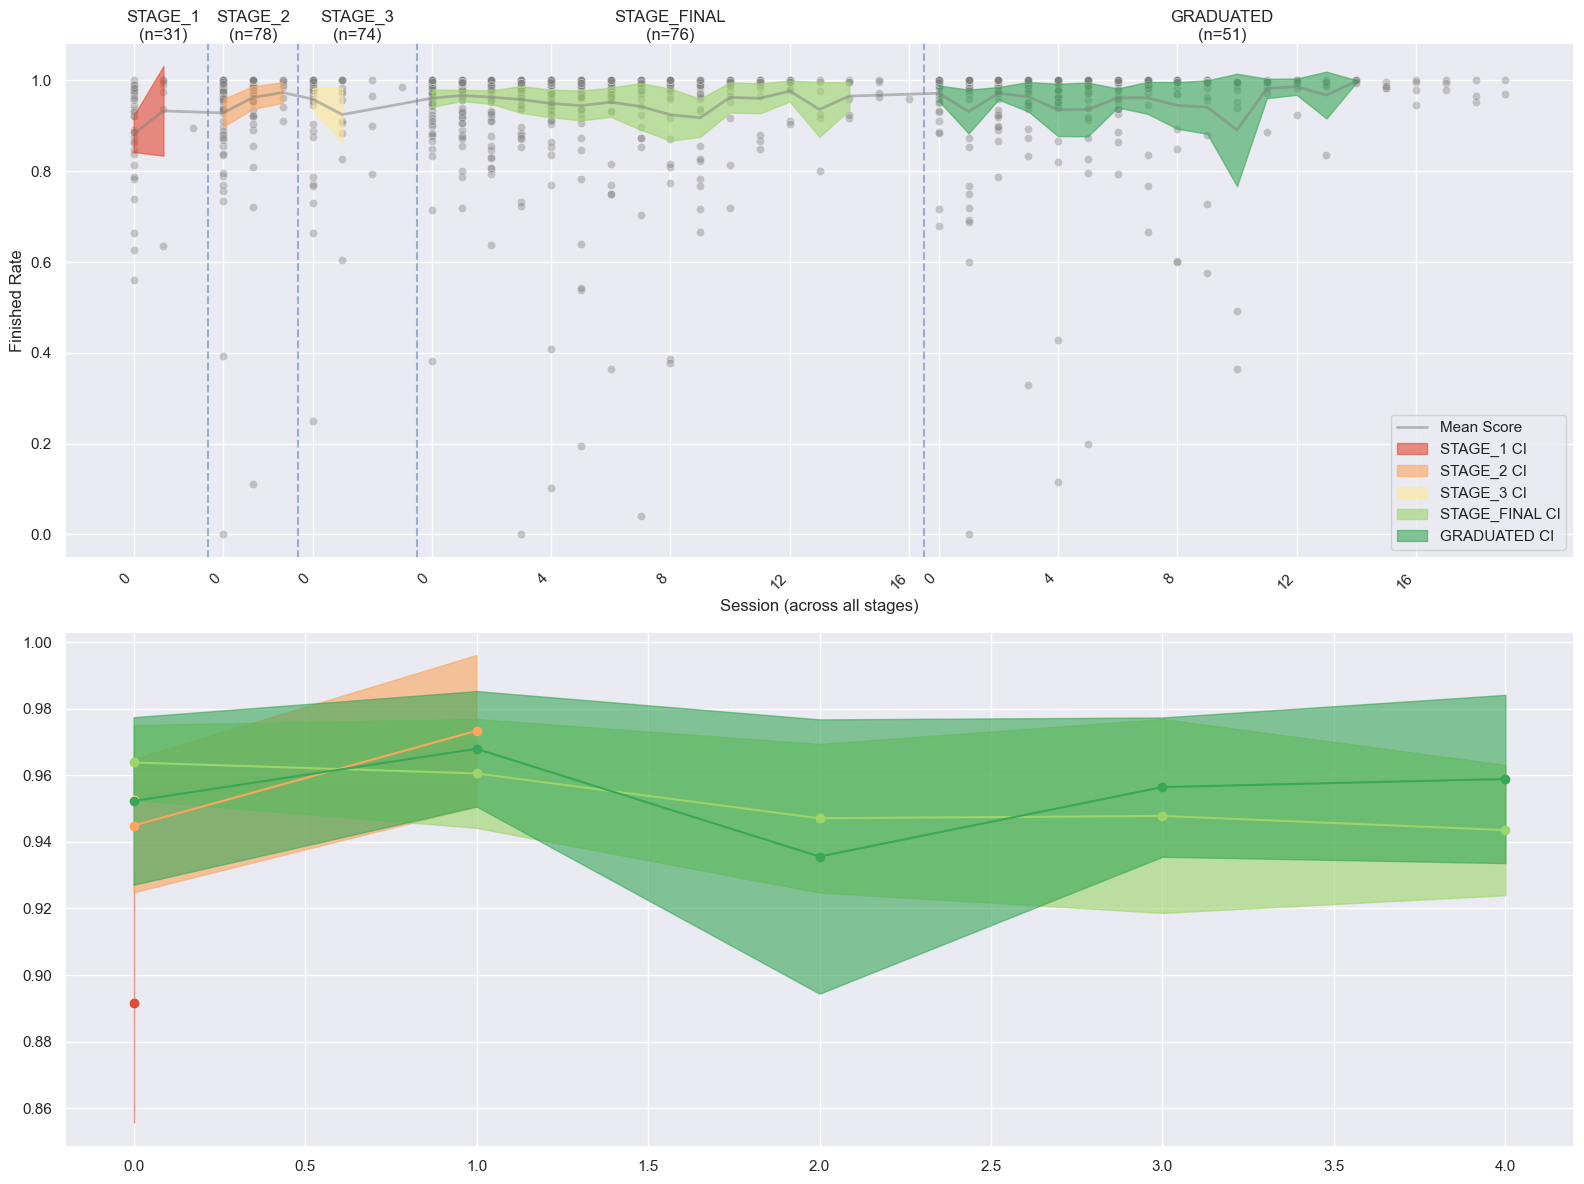


Detailed Statistics by Stage:
               N   Mean    Std    SEM   Min  Max  Subjects
Stage                                                     
GRADUATED    387  0.955  0.117  0.006  0.00  1.0        51
STAGE_1       39  0.892  0.115  0.018  0.56  1.0        31
STAGE_2      160  0.946  0.123  0.010  0.00  1.0        78
STAGE_3       92  0.953  0.106  0.011  0.25  1.0        74
STAGE_FINAL  624  0.954  0.108  0.004  0.00  1.0        76

Outlier Analysis:

STAGE_2:
Number of outliers: 3
Outlier values: [0.39338235 0.         0.11111111]
Percentage: 1.9%

STAGE_3:
Number of outliers: 2
Outlier values: [0.25       0.60409556]
Percentage: 2.2%

STAGE_FINAL:
Number of outliers: 11
Outlier values: [0.38202247 0.         0.1025641  0.40740741 0.53846154 0.54198473
 0.19444444 0.36326531 0.04       0.38666667 0.37777778]
Percentage: 1.8%

GRADUATED:
Number of outliers: 11
Outlier values: [0.         0.6        0.32900433 0.11538462 0.42857143 0.2
 0.60333333 0.6        0.57666667 0.3646209

In [87]:
au.ci_plot_metric(uni_arrays, 
           verbose=True,
           min_sample_threshold=5,
           ci_level=0.95,
           zscore_threshold=3,
           normalize_stages=True,
           ylabel='Finished Rate')

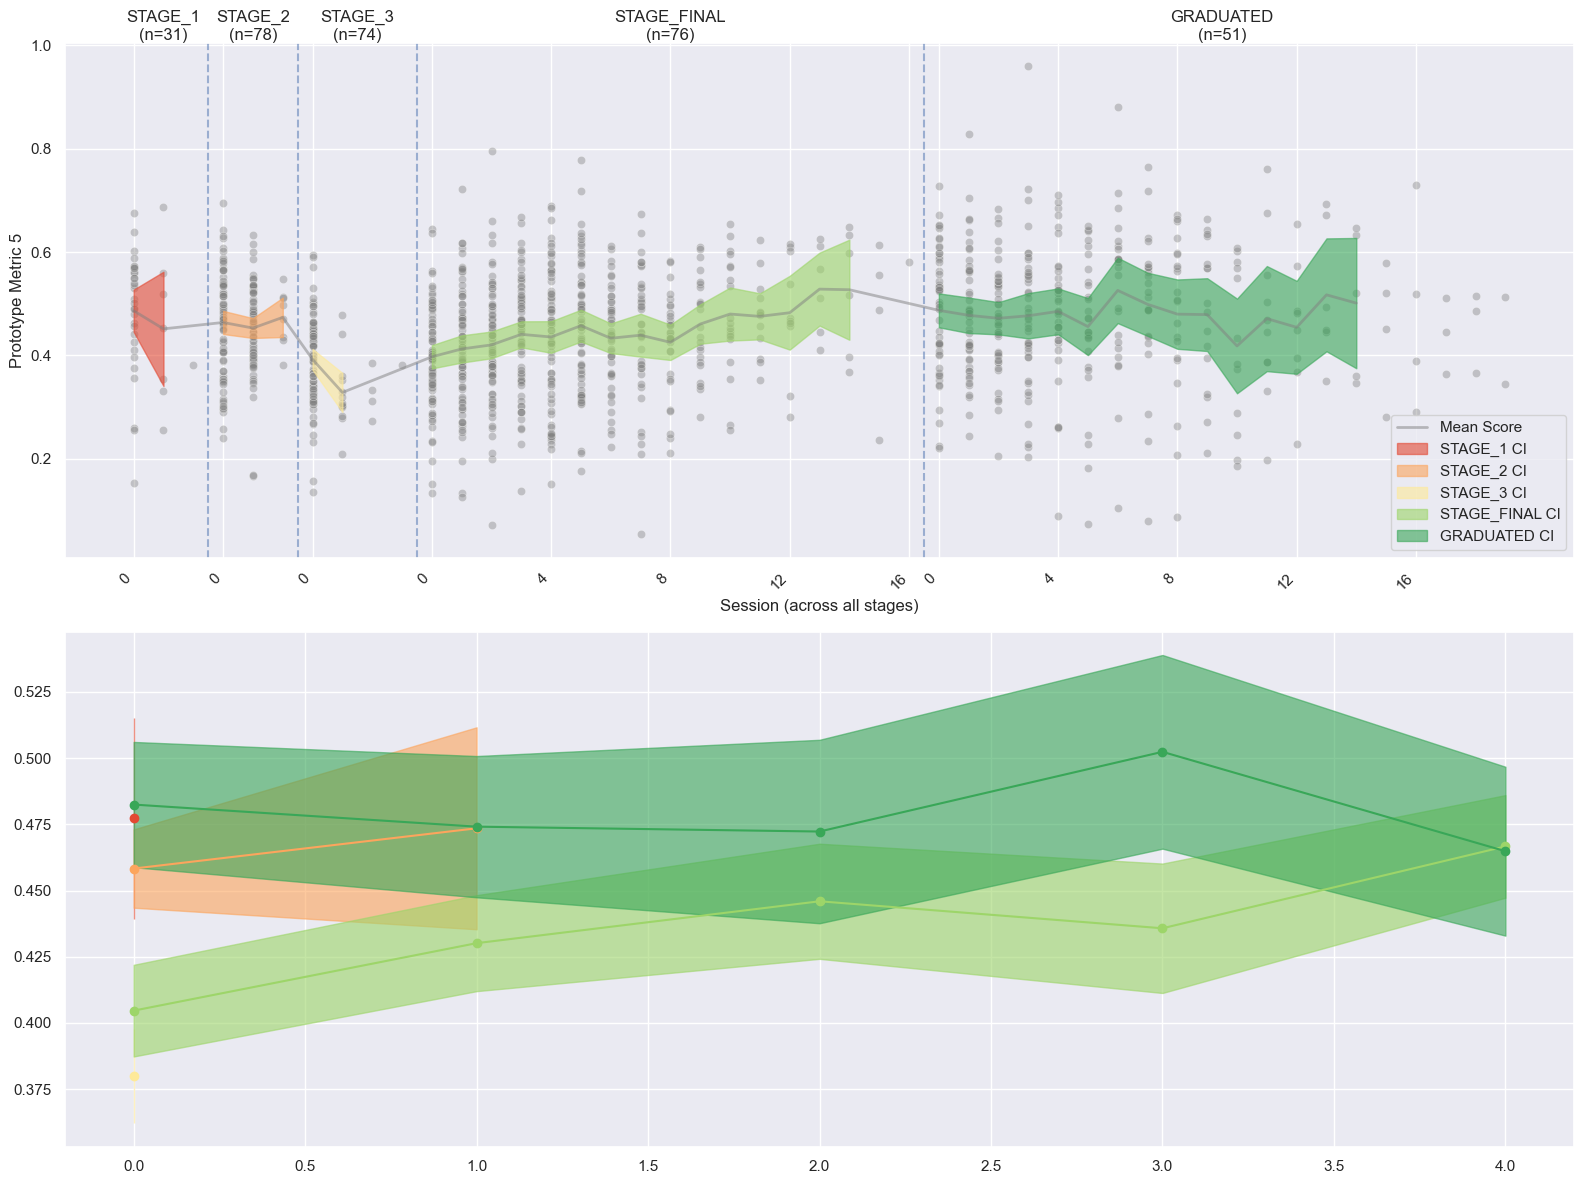


Detailed Statistics by Stage:
               N   Mean    Std    SEM    Min    Max  Subjects
Stage                                                        
GRADUATED    386  0.479  0.134  0.007  0.073  0.960        51
STAGE_1       39  0.477  0.121  0.019  0.153  0.686        31
STAGE_2      159  0.459  0.091  0.007  0.167  0.695        78
STAGE_3       92  0.380  0.088  0.009  0.136  0.595        74
STAGE_FINAL  623  0.435  0.115  0.005  0.053  0.795        76

Outlier Analysis:

STAGE_2:
Number of outliers: 2
Outlier values: [0.16666667 0.16832449]
Percentage: 1.3%

STAGE_FINAL:
Number of outliers: 3
Outlier values: [0.07182616 0.79539679 0.05333333]
Percentage: 0.5%

GRADUATED:
Number of outliers: 3
Outlier values: [0.96       0.0734127  0.88160158]
Percentage: 0.8%

Performance Summary:

STAGE_1:
Sessions: 3
Mean ± SEM: 0.469 ± 0.014
Subjects: 31
Sample size range: 1-31
Sessions below threshold: 1

STAGE_2:
Sessions: 3
Mean ± SEM: 0.463 ± 0.006
Subjects: 77
Sample size range: 8-77
S

In [88]:
au.ci_plot_metric(prot_type_five, 
           verbose=True,
           min_sample_threshold=5,
           ci_level=0.95,
           zscore_threshold=3,
           normalize_stages=True,
           ylabel='Prototype Metric 5')

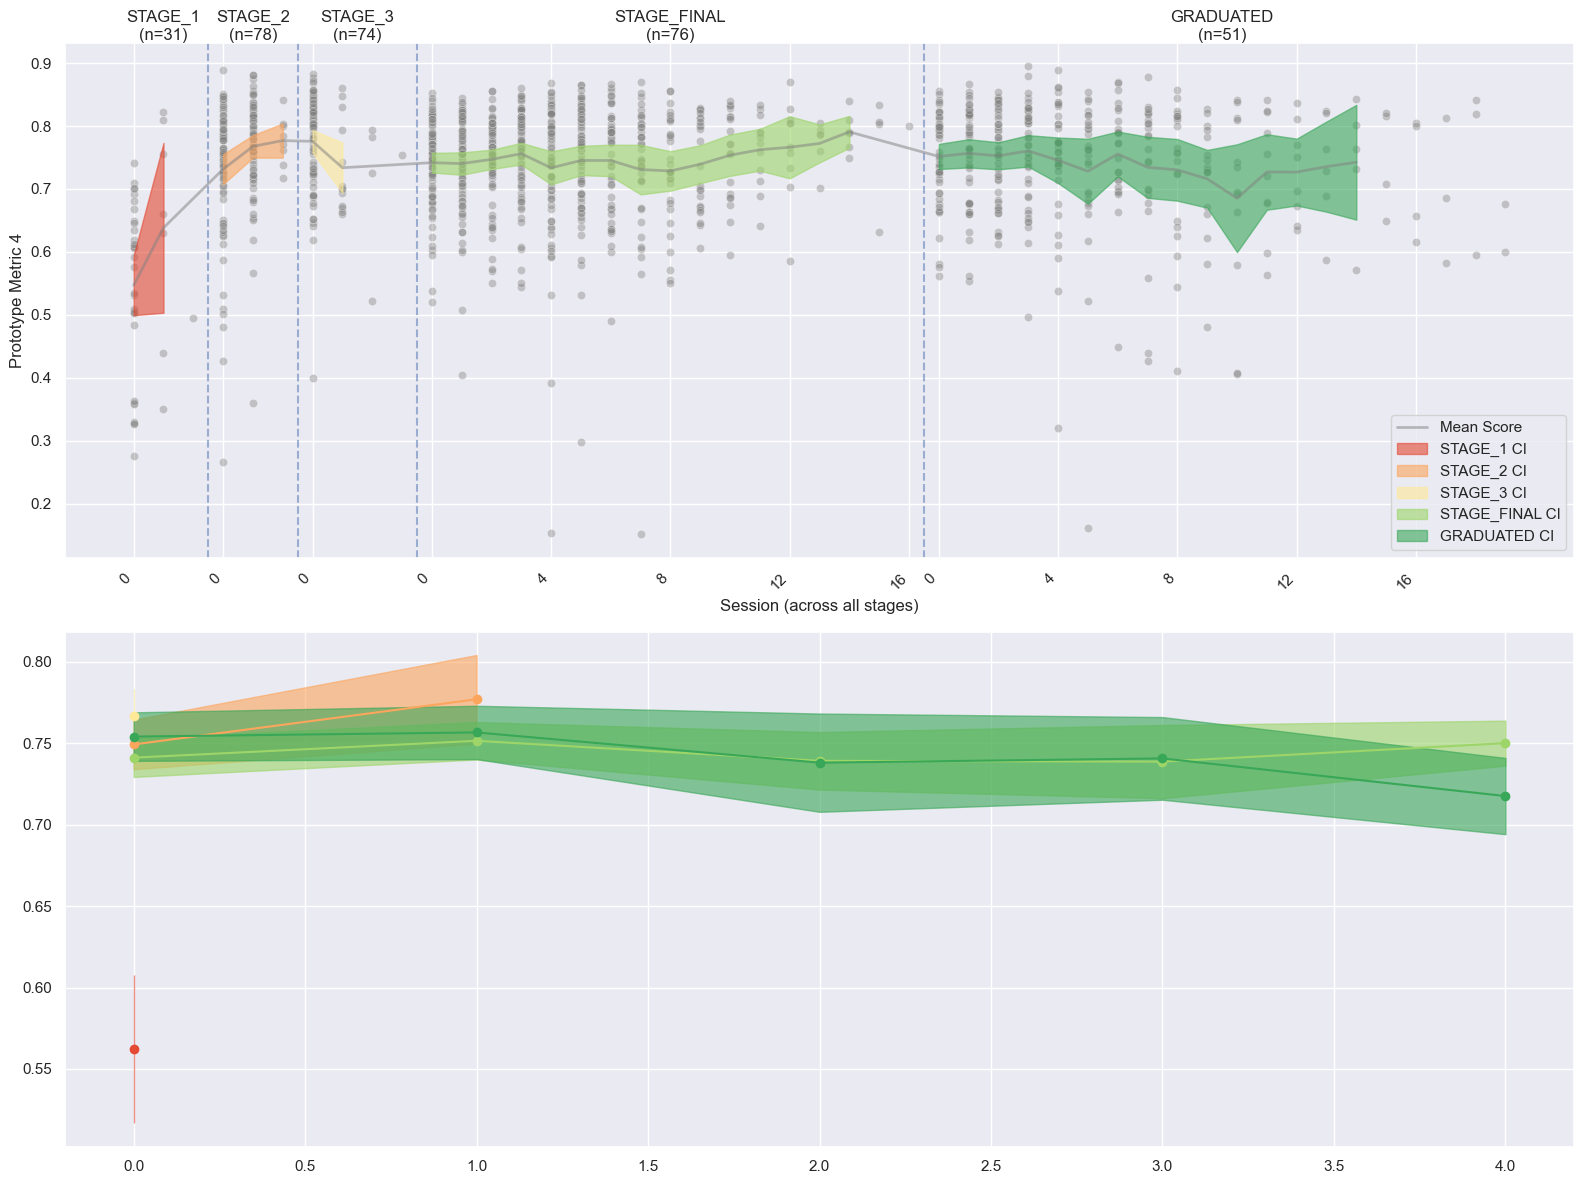


Detailed Statistics by Stage:
               N   Mean    Std    SEM    Min    Max  Subjects
Stage                                                        
GRADUATED    386  0.743  0.096  0.005  0.162  0.895        51
STAGE_1       39  0.562  0.145  0.023  0.276  0.822        31
STAGE_2      159  0.751  0.093  0.007  0.266  0.888        78
STAGE_3       92  0.766  0.081  0.008  0.400  0.883        74
STAGE_FINAL  623  0.744  0.085  0.003  0.151  0.870        76

Outlier Analysis:

STAGE_2:
Number of outliers: 3
Outlier values: [0.42717667 0.266478   0.35986343]
Percentage: 1.9%

STAGE_3:
Number of outliers: 2
Outlier values: [0.40031598 0.52123808]
Percentage: 2.2%

STAGE_FINAL:
Number of outliers: 5
Outlier values: [0.40435043 0.1528936  0.39119045 0.29799425 0.15114873]
Percentage: 0.8%

GRADUATED:
Number of outliers: 8
Outlier values: [0.32074749 0.16200244 0.44907873 0.42741326 0.43987444 0.41146935
 0.40619485 0.40818044]
Percentage: 2.1%

Performance Summary:

STAGE_1:
Sessions: 3

In [89]:
au.ci_plot_metric(prot_type_four, 
           verbose=True,
           min_sample_threshold=5,
           ci_level=0.95,
           zscore_threshold=3,
           normalize_stages=True,
           ylabel='Prototype Metric 4')